In [1]:
import torch
import random
import torch.nn as nn

random.seed(2024)

In [2]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="./datasets", name="Cora")
data = dataset[0]
train_mask = data.train_mask
test_mask = data.test_mask
val_mask = data.val_mask

In [3]:
def random_walk(sample, num_nodes, edge_index, walk_len):
    """
    params:
            sample (int), (num_samples): how many random_walk for each node
            num_nodes (int), (num_nodes):  num_nodes
            edge_index (torch.tensor), (2, 2*num_edges){undirected} (2, num_edges){directed}: [src_nodes -> des_nodes]
            walk_len (int): length of each  random_walk
    return:
            walks (torch.tensor), (walk_length, num_nodes*sample_nodes, 1)
    """
    # find out going neighbours of all nodes
    src_nodes = edge_index[0]
    des_nodes = edge_index[1]
    # # make nodes
    nodes = torch.arange(num_nodes).repeat(sample)
    # make dictionary to store each node outgoing-neigbours
    out_neig = {node: [] for node in range(num_nodes)}
    # find neigbours
    for i in range(edge_index.size(-1)):
        out_neig[src_nodes[i].item()].append(des_nodes[i])

    # total _samples is num_nodes*sample
    total_samples = num_nodes * sample

    # create walks (walk_length, num_nodes*sample_nodes, 1)
    walks = -1 * torch.ones((walk_len, total_samples, 1), dtype=torch.int32)

    # start rand_walk of length  walk_length

    for i in range(total_samples):
        # start_node
        walks[0, i, 0] = nodes[i]
        current_node = walks[0, i, 0]
        for j in range(1, walk_len):
            neig = out_neig[current_node.item()]
            if len(neig) > 0:
                current_node = random.choice(neig)  # nodes are in tensor
                walks[j, i, 0] = current_node
    # # print(walks.transpose(0,1).squeeze(-1))
    # print(walks.squeeze(-1).transpose(0, 1))
    # # call uniqueness on walks
    # unq_walk = uniqueness(walks, total_samples)

    return walks


def uniqueness(walks, total_samples):
    """
    params:
            walks(torch.tensor), (walk_length, num_nodes * sample_nodes, 1):
            total_samples(int), (num_nodes*sample): total samples
    return:
            unique_walks(torch.tensor), (walk_length, num_nodes * sample_nodes, 1):
    """
    # uniqueness_walk = torch.tenosr
    for i in range(total_samples):
        c = 0
        om = {}
        unique_walks = torch.empty_like(walks)
        for j, current_node in enumerate(walks[:, i, 0]):
            if current_node.item() not in om:
                om[current_node.item()] = c
                c += 1
            unique_walks[j, i, 0] = om[current_node.item()]

    # this is inplace change of walks to unique walks
    # so make sure to call randomd_walk before unique_wals if want walks
    return unique_walks  # => unique_walks


In [4]:
class RumLayer(nn.Module):
    def __init__(
        self,
        num_nodes,
        sample,
        x_input_dim,
        hidden_state_dim,
        walk_len,
        rnd_walk: callable = random_walk,
        uniq_walk=uniqueness,
        **kwargs,
    ):
        """
        params:
                num_nodes (int) (num_nodes): number of nodes
                sample (int) (num_sample): number of random_walk for each node
                x_input_dim (tensor) (num_nodes, in_dim): features of each nodes
                hidden_state_dim (tensor) (dim_hidden_state): hidden state dim and out dim of if srnn
                rnd_walk (function) : calculates uniqueness
                        params:
                                sample (int), (num_samples): how many random_walk for each node
                                num_nodes (int), (num_nodes):  num_nodes
                                edge_index (torch.tensor), (2, 2*num_edges){undirected} (2, num_edges){directed}: [src_nodes -> des_nodes]
                                walk_len (int): length of each  random_walk
                        return:
                                uniqueness_walks (torch.tensor), (walk_length, num_nodes*sample_nodes, 1)
                uniqu_walks (function) : calculate unique_walks
                        params:
                                walks(torch.tensor), (walk_length, num_nodes * sample_nodes, 1):
                                total_samples(int), (num_nodes*sample): total samples
                        return:
                                unique_walks(torch.tensor), (walk_length, num_nodes * sample_nodes, 1):
            return:
                    emb (tensor) (num_nodes, hidden_state_dim)
        """
        super().__init__()
        self.rnn_walk = nn.GRU(2, hidden_state_dim, bidirectional=True)
        self.rnn_x = nn.GRU(x_input_dim, hidden_state_dim)

        self.num_nodes = num_nodes
        self.sample = sample
        self.x_input_dim = x_input_dim
        self.hidden_state_dim = hidden_state_dim
        self.total_samples = sample * num_nodes
        self.random_walk = rnd_walk
        self.uniq_walks = uniq_walk
        self.walk_len = walk_len

    def forward(self, x, edge_index):
        """ """
        # create initial hidden state,h0_walk (2, total_samples, hidden_state_dim)
        # h0_walk = torch.zeros(
        #     (2, self.total_samples, self.hidden_state_dim), dtype=torch.float32
        # )
        # Perform random walks
        walks = self.random_walk(self.sample, self.num_nodes, edge_index, self.walk_len)

        # Extract features for the sampled nodes

        x = x[
            walks.squeeze(-1)
        ]  # (walk_length, num_nodes*sample_nodes, 1, x_input_dim)

        # Calculate unique walks
        uniq_walks = self.uniq_walks(
            walks, self.total_samples
        )  # (walk_length, num_nodes*sample_nodes, 1)
        uniq_walks = uniq_walks / uniq_walks.size(0)
        uniq_walks = uniq_walks * torch.pi * 2

        # Convert uniqueness to sine and cosine components
        uniq_walks_sin, uniq_walks_cos = torch.sin(uniq_walks), torch.cos(uniq_walks)
        uniq_walks = torch.cat(
            [uniq_walks_sin, uniq_walks_cos], dim=-1
        )  # (walk_length, num_nodes*sample_nodes, 2)

        # Apply RNN to unique walks
        _, h_walk = self.rnn_walk(
            uniq_walks, #h0_walk
        )  # h_walk shape: (2, total_samples, hidden_state_dim)

        # take mean as rnn_x is unidirection
        h_walk = torch.mean(h_walk, dim=0, keepdim=True)

        # Apply RNN to input features
        _, h = self.rnn_x(x, h_walk)

        # h is (1, total_samples, hidden_state_dim)
        # but for emb i need  ( num_nodes, hidden_state_dim)
        # so i tak avg of a node in each sample
        # total_sample = num_nodes *  sample
        # so i need emd to be in shape of (sample, num_nodes, hidden_state_dim)
        

        h = h.view(self.sample, self.num_nodes, self.hidden_state_dim)

        # now take mean along  num_sample
        h = torch.mean(h, dim=0)  # (num_nodes, hidden_state_dim)
        # h = nn.LogSigmoid()(h)
        return h


In [5]:
class RUMModel(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: int,
        depth: int,
        num_nodes: int,
        sample: int,
        walk_len: int,
        activation: callable = torch.nn.ELU(),
    ):
        super().__init__()
        torch.manual_seed(2024)
        self.layers = nn.ModuleList()
        # input linear layer
        self.fc_in = nn.Linear(in_features, hidden_features, bias=True)
        # RumLayer
        for _ in range(depth):
            self.layers.append(
                RumLayer(
                    x_input_dim=hidden_features,
                    hidden_state_dim=hidden_features,
                    num_nodes=num_nodes,
                    sample=sample,
                    walk_len=walk_len,
                )
            )
        # output linear layer
        self.fc_out = nn.Linear(hidden_features, out_features, bias=True)

        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.depth = depth
        self.activation = activation

    def forward(self, x, edge_index):
        x = nn.Dropout(p=0.2)(x)
        x = self.fc_in(x)
        x = self.activation(x)
        for rum in self.layers:
            # Save the input for the skip connection
            skip_connection = x
            x = rum(x, edge_index)
            x = x + skip_connection  # Skip connection
        x = nn.Dropout(p=0.2)(x)
        x = self.fc_out(x)
        x = nn.LogSoftmax(dim=-1)(x)
        return x

In [6]:
# Initialize model
in_features = dataset.num_node_features  # Number of input features per node
out_features = dataset.num_classes  # Number of output classes
hidden_features = 64  # You can adjust the hidden dimension
depth = 2  # Number of RUMLayers in the model
sample = 3
walk_len = 8
model = RUMModel(
    in_features=in_features,
    out_features=out_features,
    hidden_features=hidden_features,
    depth=depth,
    num_nodes=data.num_nodes,
    sample=sample,
    walk_len=walk_len,
)  # Move the model to the appropriate device
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()

In [7]:
def train():
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    return loss.item()


In [8]:
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=-1)

        acc = []
        for mask in [train_mask, val_mask, test_mask]:
            correct = (pred[mask] == data.y[mask]).sum().item()
            total = mask.sum().item()
            acc.append(correct / total)

    return acc


In [9]:

# for epoch in range(1, 101):
#     loss = train()
#     train_acc, val_acc, test_acc = test()
#     print(f"epoch:{epoch} train_loss {loss:.4f} train_acc:{train_acc:.4f}, val_acc:{val_acc:4f}, test_acc:{test_acc:4f}")


Early stopping at epoch 35 for sample 1, walk_len 1.
Best test accuracy for sample 1, walk_len 1: 0.5020
Early stopping at epoch 42 for sample 1, walk_len 2.
Best test accuracy for sample 1, walk_len 2: 0.6480
Early stopping at epoch 39 for sample 1, walk_len 3.
Best test accuracy for sample 1, walk_len 3: 0.6610
Early stopping at epoch 37 for sample 1, walk_len 4.
Best test accuracy for sample 1, walk_len 4: 0.6960
Early stopping at epoch 35 for sample 1, walk_len 5.
Best test accuracy for sample 1, walk_len 5: 0.6790
Early stopping at epoch 39 for sample 1, walk_len 6.
Best test accuracy for sample 1, walk_len 6: 0.6770
Early stopping at epoch 39 for sample 1, walk_len 7.
Best test accuracy for sample 1, walk_len 7: 0.7090
Early stopping at epoch 41 for sample 1, walk_len 8.
Best test accuracy for sample 1, walk_len 8: 0.6870
Early stopping at epoch 37 for sample 2, walk_len 1.
Best test accuracy for sample 2, walk_len 1: 0.4780
Early stopping at epoch 63 for sample 2, walk_len 2.
Be

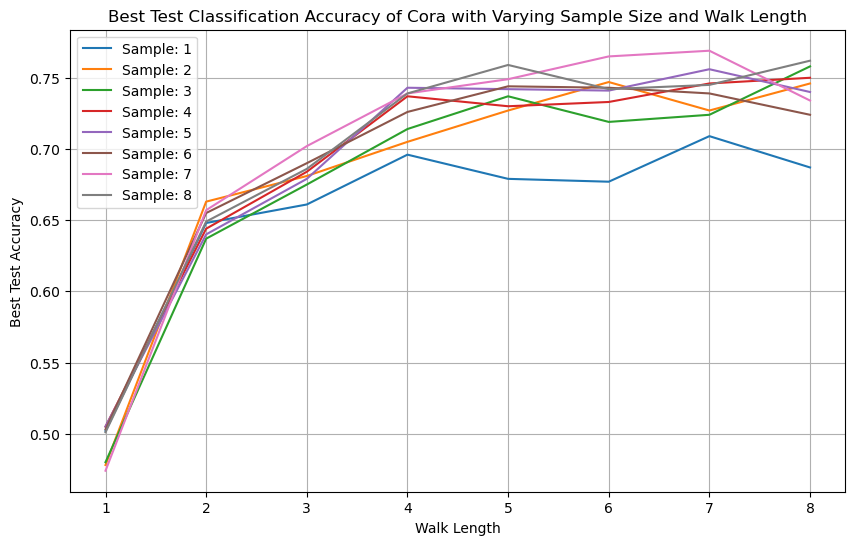

In [ ]:
import matplotlib.pyplot as plt
import torch

samples_range = [1, 2, 3, 4, 5, 6, 7, 8]
walk_len_range = [1, 2, 3, 4, 5, 6, 7, 8]
results = {}

# Iterate through different samples and walk lengths
for sample in samples_range:
    for walk_len in walk_len_range:
        # Initialize model
        model = RUMModel(
            in_features=dataset.num_node_features,
            out_features=dataset.num_classes,
            hidden_features=64,
            depth=1,
            num_nodes=data.num_nodes,
            sample=sample,
            walk_len=walk_len,
        )

        # Define optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)

        best_test_acc = 0  # Initialize the best test accuracy for this configuration
        best_val_acc = 0  # Track the best validation accuracy for early stopping
        patience = 25  # Set the patience for early stopping
        counter = 0  # Initialize the counter for early stopping

        # Train model with early stopping after 100 epochs
        for epoch in range(1, 101):
            train_loss = train()  # Simplified train function

            # Test model
            train_acc, val_acc, test_acc = test()  # Simplified test function

            # Check if validation accuracy has improved
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test_acc = (
                    test_acc  # Update best test accuracy if validation improves
                )
                counter = 0  # Reset the counter
            else:
                counter += 1  # Increment the counter if no improvement

            # Early stopping condition (check only after 100 epochs)
            if counter >= patience:
                print(
                    f"Early stopping at epoch {epoch} for sample {sample}, walk_len {walk_len}."
                )
                break  # Stop training if patience is exceeded

        # Store the best test accuracy for this sample and walk_len combination
        results[(sample, walk_len)] = best_test_acc

        # Print the best accuracy for the current (sample, walk_len)
        print(
            f"Best test accuracy for sample {sample}, walk_len {walk_len}: {best_test_acc:.4f}"
        )

import json

results_file = "test_accuracy_results.json"
json_serializable_results = {str(key): value for key, value in results.items()}

with open(results_file, "w") as f:
    json.dump(json_serializable_results, f, indent=4)
print(f"Results saved to {results_file}")


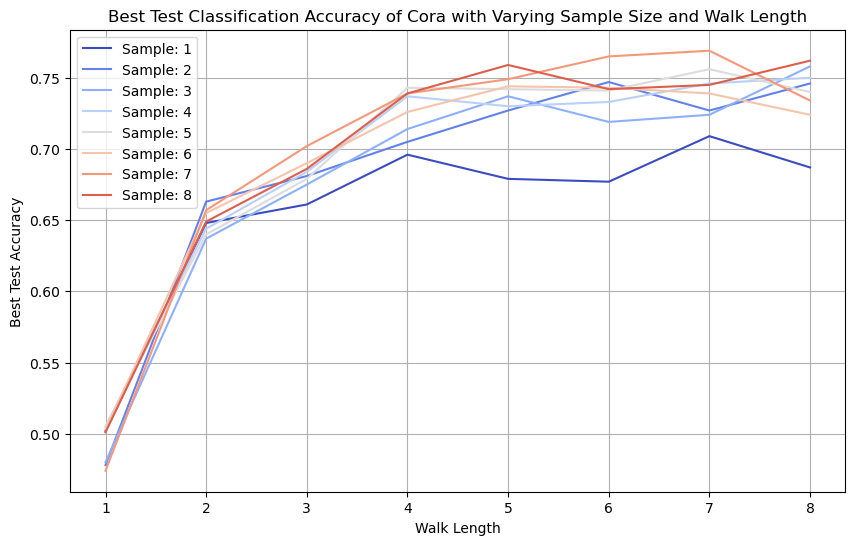

Line plot saved to test_accuracy_plot_colored.png


In [28]:

import matplotlib as mpl

# Define the colormap without using the deprecated method
colors = mpl.colormaps[
    "coolwarm"
]  # Use 'matplotlib.colormaps' instead of 'cm.get_cmap()'

# Prepare data for plotting, ensure the results dictionary is complete
test_accuracies = [
    [results.get((sample, walk_len), 0) for walk_len in walk_len_range]
    for sample in samples_range
]

# Plot results with the new color map
plt.figure(figsize=(10, 6))
for i, sample in enumerate(samples_range):
    plt.plot(
        walk_len_range,
        test_accuracies[i],
        label=f"Sample: {sample}",
        color=colors(i / len(samples_range)),
    )  # Use the colormap

plt.xlabel("Walk Length")
plt.ylabel("Best Test Accuracy")
plt.title(
    "Best Test Classification Accuracy of Cora with Varying Sample Size and Walk Length"
)
plt.legend()
plt.grid(True)

# Save the plot as an image file
plt.savefig("test_accuracy_plot_colored.png")  # Save the plot

plt.show()

print("Line plot saved to test_accuracy_plot_colored.png")


Plot saved to test_accuracy_mesh_plot.png


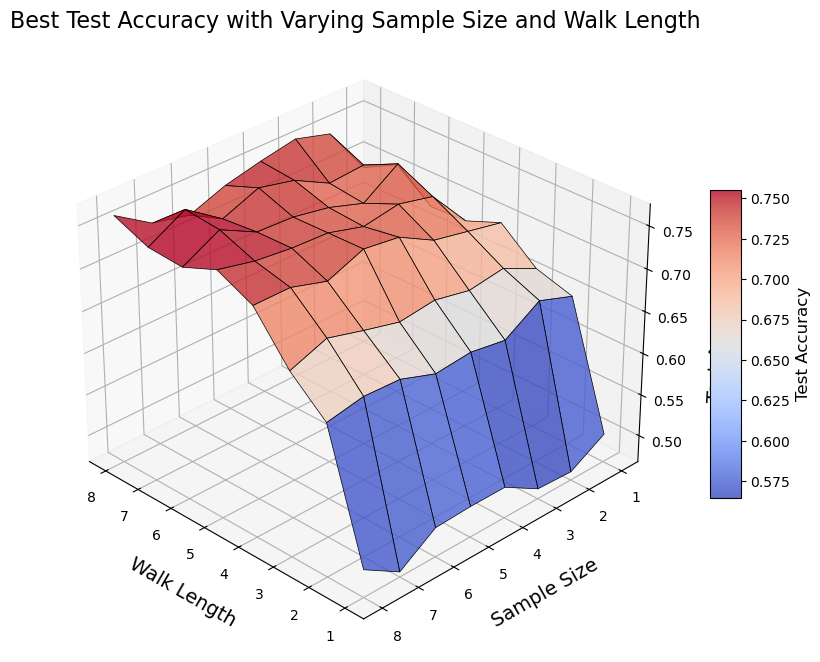

In [29]:
# Save results to a JSON file
# Save results to a JSON file (convert tuple keys to strings)
import matplotlib.pyplot as plt
import numpy as np
import torch
# Prepare data for plotting
X, Y = np.meshgrid(walk_len_range, samples_range)
Z = np.array(
    [
        [results.get((sample, walk_len), 0) for walk_len in walk_len_range]
        for sample in samples_range
    ]
)

# Create a 3D figure
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Customize plot surface
surf = ax.plot_surface(
    X,
    Y,
    Z,
    cmap="coolwarm",  # Colormap for better visualization
    edgecolor="k",  # Add black edges for clarity
    linewidth=0.5,  # Thin edges for a neat look
    alpha=0.8,  # Slight transparency for depth
)

# Add a color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Test Accuracy", fontsize=12)

# Set axis labels
ax.set_xlabel("Walk Length", fontsize=14, labelpad=10)
ax.set_ylabel("Sample Size", fontsize=14, labelpad=10)
ax.set_zlabel("Test Accuracy", fontsize=14, labelpad=10)

# Set title
ax.set_title(
    "Best Test Accuracy with Varying Sample Size and Walk Length", fontsize=16, loc="center"
)

# Adjust viewing angle for better visibility
ax.view_init(elev=30, azim=135)

# Save the plot as an image file
plot_file = "test_accuracy_mesh_plot.png"
plt.savefig(plot_file, dpi=300, bbox_inches="tight")
print(f"Plot saved to {plot_file}")

plt.show()
